# Stacked LSTM regression

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
TIMESTEPS = 12  # Input 12 months to predict next month

## 1. Read in dataset

In [15]:
data = pd.read_csv('airline-passengers.csv')
data.index = pd.to_datetime(data.Month)
data.drop(['Month'], axis=1, inplace=True)


<Axes: title={'center': 'Monthly airline passengers'}, xlabel='Month'>

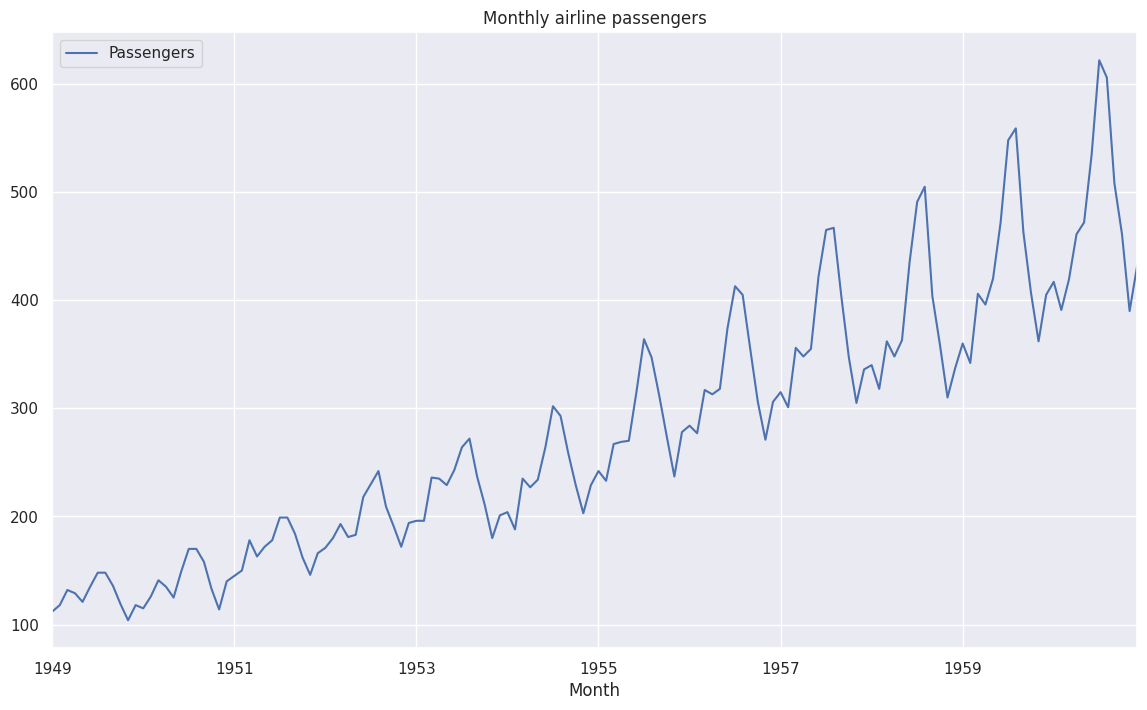

In [16]:
data.plot(figsize=(14, 8), title='Monthly airline passengers')

## 2.1 Normalize dataset

<Axes: title={'center': 'Monthly normalized airline passengers'}, xlabel='Month'>

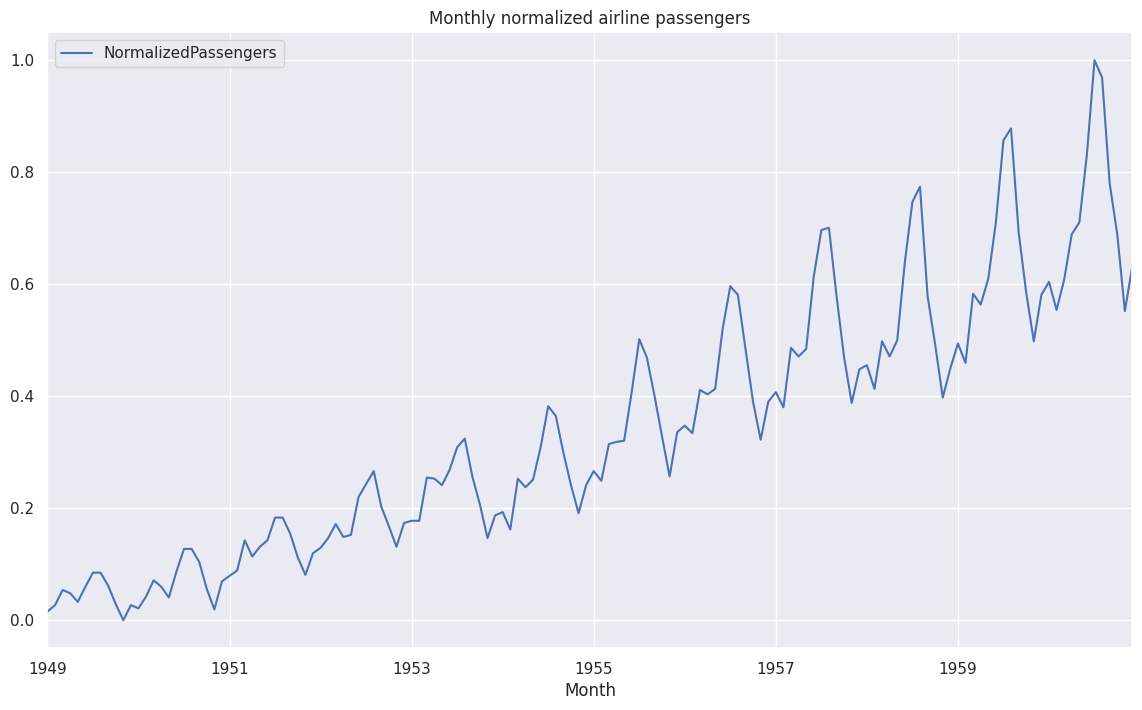

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedPassengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1)).flatten()
data[['NormalizedPassengers']].plot(figsize=(14, 8), title='Monthly normalized airline passengers')

## 2.2 Preprocess dataset

In [18]:
def create_dataset(data, timesteps=TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        timesteps (int, default: TIMESTEPS): Input time length
    Returns:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X, y, y_date, start_values = [], [], [], []

    for i in range(len(data) - timesteps):
        Xt = data.iloc[i:i+timesteps].values
        yt = data.iloc[i+timesteps]
        yt_date = data.index[i+timesteps].to_pydatetime()

        # Subtract a start value from each values in the timestep.
        start_value = Xt[0]
        Xt = Xt - start_value
        yt = yt - start_value

        X.append(Xt)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)

    return np.array(X), np.array(y), y_date, start_values

In [19]:
def split_train_valid_test(X, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_train (pandas.DataFrame)
        X_valid (pandas.DataFrame)
        X_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])

    X_train = X[:train_end_idx+1, :]
    X_valid = X[train_end_idx+1:valid_end_idx+1, :]
    X_test = X[valid_end_idx+1:, :]

    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]

    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]

    return X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [20]:
# Create input and output pairs for training lstm.
X, y, y_date, start_values = create_dataset(data[['NormalizedPassengers']])

# Split X and y into train, valid, and test periods.
X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X, y, y_date)

In [21]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(84, 12, 1) (24, 12, 1) (24, 12, 1)
(84, 1) (24, 1) (24, 1)


## 3. Create stacked LSTM regression model

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [47]:
# Define callbacks for training
es = EarlyStopping(
    monitor='val_mean_absolute_error',
    min_delta=0,
    patience=15,
    verbose=1,
    mode='auto'
)

In [48]:

fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [45]:
# Create and compile model using your function
TIMESTEPS = X_train.shape[1]
model = create_model(timesteps=TIMESTEPS)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,201 (340.63 KB)

 Trainable params: 87,201 (340.63 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Train the model
fit = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,  # Use 100 to start (1000 is very long)
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

Epoch 1/100


3/3 - 4s - 1s/step - loss: 0.0192 - mean_absolute_error: 0.1143 - val_loss: 0.0043 - val_mean_absolute_error: 0.0530
Epoch 2/100


3/3 - 1s - 248ms/step - loss: 0.0027 - mean_absolute_error: 0.0419 - val_loss: 0.0023 - val_mean_absolute_error: 0.0388
Epoch 3/100


3/3 - 0s - 88ms/step - loss: 0.0013 - mean_absolute_error: 0.0292 - val_loss: 0.0018 - val_mean_absolute_error: 0.0351
Epoch 4/100


3/3 - 0s - 55ms/step - loss: 0.0016 - mean_absolute_error: 0.0338 - val_loss: 0.0011 - val_mean_absolute_error: 0.0287
Epoch 5/100
3/3 - 0s - 93ms/step - loss: 0.0010 - mean_absolute_error: 0.0250 - val_loss: 0.0016 - val_mean_absolute_error: 0.0322
Epoch 6/100
3/3 - 0s - 50ms/step - loss: 0.0012 - mean_absolute_error: 0.0288 - val_loss: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 7/100


3/3 - 0s - 55ms/step - loss: 8.9984e-04 - mean_absolute_error: 0.0240 - val_loss: 0.0011 - val_mean_absolute_error: 0.0290
Epoch 8/100


3/3 - 0s - 55ms/step - loss: 0.0010 - mean_absolute_error: 0.0258 - val_loss: 0.0011 - val_mean_absolute_error: 0.0286
Epoch 9/100
3/3 - 0s - 47ms/step - loss: 9.2365e-04 - mean_absolute_error: 0.0246 - val_loss: 0.0011 - val_mean_absolute_error: 0.0277
Epoch 10/100
3/3 - 0s - 47ms/step - loss: 9.0346e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0012 - val_mean_absolute_error: 0.0277
Epoch 11/100
3/3 - 0s - 46ms/step - loss: 9.2119e-04 - mean_absolute_error: 0.0248 - val_loss: 0.0011 - val_mean_absolute_error: 0.0274
Epoch 12/100


3/3 - 0s - 56ms/step - loss: 8.5218e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0010 - val_mean_absolute_error: 0.0273
Epoch 13/100


3/3 - 0s - 99ms/step - loss: 8.6202e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0010 - val_mean_absolute_error: 0.0272
Epoch 14/100
3/3 - 0s - 91ms/step - loss: 8.5308e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0010 - val_mean_absolute_error: 0.0269
Epoch 15/100
3/3 - 0s - 69ms/step - loss: 8.3934e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0011 - val_mean_absolute_error: 0.0267
Epoch 16/100
3/3 - 0s - 109ms/step - loss: 8.4199e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0010 - val_mean_absolute_error: 0.0265
Epoch 17/100


3/3 - 0s - 113ms/step - loss: 8.2143e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0010 - val_mean_absolute_error: 0.0263
Epoch 18/100


3/3 - 0s - 94ms/step - loss: 8.1495e-04 - mean_absolute_error: 0.0228 - val_loss: 9.9346e-04 - val_mean_absolute_error: 0.0262
Epoch 19/100
3/3 - 0s - 79ms/step - loss: 8.1206e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0010 - val_mean_absolute_error: 0.0259
Epoch 20/100
3/3 - 0s - 89ms/step - loss: 8.0564e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0010 - val_mean_absolute_error: 0.0256
Epoch 21/100
3/3 - 0s - 97ms/step - loss: 8.0182e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 22/100


3/3 - 0s - 104ms/step - loss: 7.9204e-04 - mean_absolute_error: 0.0229 - val_loss: 9.8768e-04 - val_mean_absolute_error: 0.0253
Epoch 23/100


3/3 - 0s - 89ms/step - loss: 7.8673e-04 - mean_absolute_error: 0.0227 - val_loss: 9.8336e-04 - val_mean_absolute_error: 0.0252
Epoch 24/100
3/3 - 0s - 61ms/step - loss: 7.8326e-04 - mean_absolute_error: 0.0227 - val_loss: 9.9473e-04 - val_mean_absolute_error: 0.0250
Epoch 25/100
3/3 - 0s - 60ms/step - loss: 7.7927e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0010 - val_mean_absolute_error: 0.0249
Epoch 26/100
3/3 - 0s - 85ms/step - loss: 7.7443e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0010 - val_mean_absolute_error: 0.0248
Epoch 27/100
3/3 - 0s - 49ms/step - loss: 7.6863e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0010 - val_mean_absolute_error: 0.0248
Epoch 28/100
3/3 - 0s - 48ms/step - loss: 7.6520e-04 - mean_absolute_error: 0.0226 - val_loss: 0.0010 - val_mean_absolute_error: 0.0247
Epoch 29/100
3/3 - 0s - 52ms/step - loss: 7.6209e-04 - mean_absolute_error: 0.0226 - val_loss: 0.0010 - val_mean_absolute_error: 0.0246
Epoch 30/100
3/3 - 0s - 48ms/step - loss: 7.5849e-04 

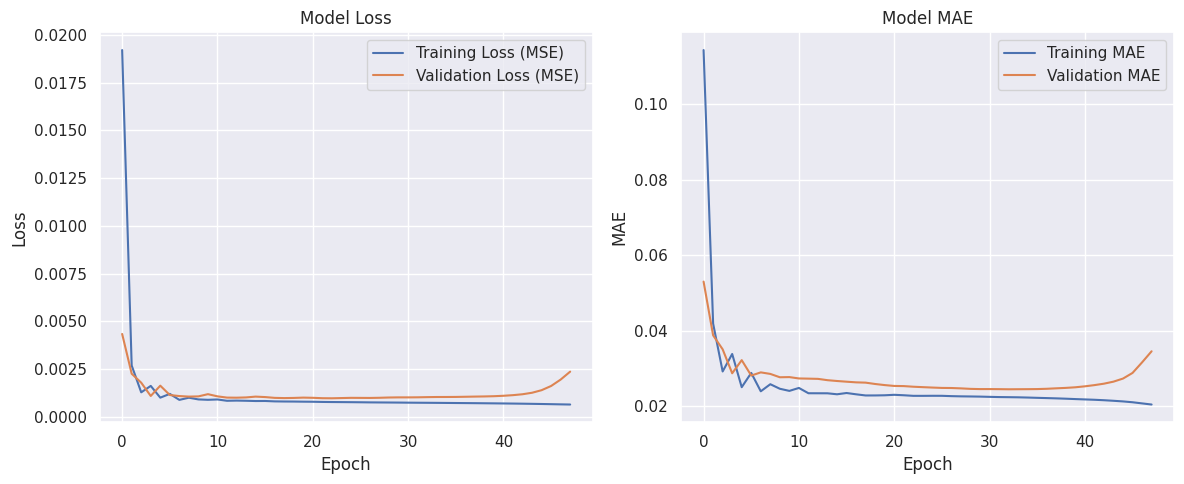

In [50]:

# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot loss (MSE)
axL.plot(fit.history['loss'], label="Training Loss (MSE)")
axL.plot(fit.history['val_loss'], label="Validation Loss (MSE)")
axL.set_title('Model Loss')
axL.set_xlabel('Epoch')
axL.set_ylabel('Loss')
axL.legend(loc='upper right')

# Plot MAE
axR.plot(fit.history['mean_absolute_error'], label="Training MAE")
axR.plot(fit.history['val_mean_absolute_error'], label="Validation MAE")
axR.set_title('Model MAE')
axR.set_xlabel('Epoch')
axR.set_ylabel('MAE')
axR.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [51]:
#  Load best saved model
model = load_model(fn)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,201 (340.63 KB)

 Trainable params: 87,201 (340.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


3/3 - 4s - 1s/step - loss: 0.0135 - mean_absolute_error: 0.0965 - val_loss: 0.0041 - val_mean_absolute_error: 0.0501
Epoch 2/100


3/3 - 1s - 247ms/step - loss: 0.0024 - mean_absolute_error: 0.0381 - val_loss: 0.0021 - val_mean_absolute_error: 0.0369
Epoch 3/100


3/3 - 0s - 55ms/step - loss: 0.0012 - mean_absolute_error: 0.0281 - val_loss: 0.0016 - val_mean_absolute_error: 0.0339
Epoch 4/100


3/3 - 0s - 113ms/step - loss: 0.0014 - mean_absolute_error: 0.0307 - val_loss: 0.0011 - val_mean_absolute_error: 0.0283
Epoch 5/100
3/3 - 0s - 89ms/step - loss: 0.0010 - mean_absolute_error: 0.0254 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301
Epoch 6/100


3/3 - 0s - 97ms/step - loss: 0.0010 - mean_absolute_error: 0.0265 - val_loss: 0.0011 - val_mean_absolute_error: 0.0282
Epoch 7/100
3/3 - 0s - 46ms/step - loss: 9.1879e-04 - mean_absolute_error: 0.0240 - val_loss: 0.0011 - val_mean_absolute_error: 0.0292
Epoch 8/100


3/3 - 0s - 56ms/step - loss: 9.5747e-04 - mean_absolute_error: 0.0250 - val_loss: 0.0011 - val_mean_absolute_error: 0.0279
Epoch 9/100
3/3 - 0s - 98ms/step - loss: 8.8098e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0012 - val_mean_absolute_error: 0.0276
Epoch 10/100
3/3 - 0s - 60ms/step - loss: 9.1520e-04 - mean_absolute_error: 0.0247 - val_loss: 0.0011 - val_mean_absolute_error: 0.0274
Epoch 11/100


3/3 - 0s - 80ms/step - loss: 8.5275e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0010 - val_mean_absolute_error: 0.0272
Epoch 12/100


3/3 - 0s - 115ms/step - loss: 8.5046e-04 - mean_absolute_error: 0.0232 - val_loss: 0.0010 - val_mean_absolute_error: 0.0272
Epoch 13/100
3/3 - 0s - 85ms/step - loss: 8.4573e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0010 - val_mean_absolute_error: 0.0267
Epoch 14/100
3/3 - 0s - 85ms/step - loss: 8.3174e-04 - mean_absolute_error: 0.0231 - val_loss: 0.0011 - val_mean_absolute_error: 0.0264
Epoch 15/100
3/3 - 0s - 91ms/step - loss: 8.3067e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0010 - val_mean_absolute_error: 0.0261
Epoch 16/100


3/3 - 0s - 86ms/step - loss: 8.0848e-04 - mean_absolute_error: 0.0230 - val_loss: 9.9808e-04 - val_mean_absolute_error: 0.0260
Epoch 17/100


3/3 - 0s - 105ms/step - loss: 8.0437e-04 - mean_absolute_error: 0.0228 - val_loss: 9.9151e-04 - val_mean_absolute_error: 0.0258
Epoch 18/100
3/3 - 0s - 80ms/step - loss: 7.9847e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0010 - val_mean_absolute_error: 0.0253
Epoch 19/100
3/3 - 0s - 83ms/step - loss: 7.9330e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0010 - val_mean_absolute_error: 0.0251
Epoch 20/100
3/3 - 0s - 69ms/step - loss: 7.8545e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0010 - val_mean_absolute_error: 0.0251
Epoch 21/100
3/3 - 0s - 47ms/step - loss: 7.7624e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0010 - val_mean_absolute_error: 0.0251
Epoch 22/100
3/3 - 0s - 100ms/step - loss: 7.7326e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0010 - val_mean_absolute_error: 0.0249
Epoch 23/100
3/3 - 0s - 100ms/step - loss: 7.6936e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0010 - val_mean_absolute_error: 0.0247
Epoch 24/100
3/3 - 0s - 59ms/step - loss: 7.6478e-04 -

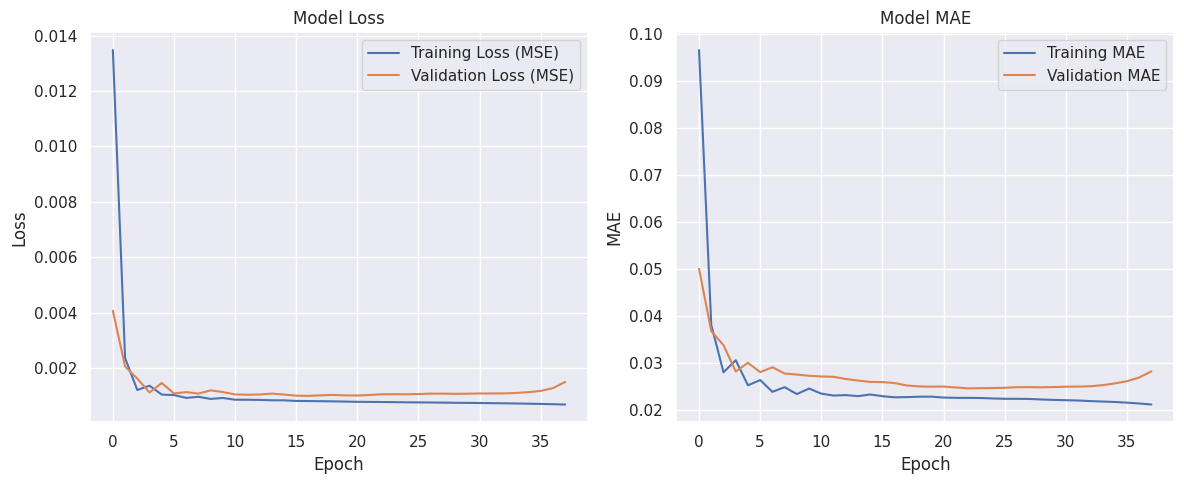

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ✅ Define callbacks for training
es = EarlyStopping(
    monitor='val_mean_absolute_error',
    min_delta=0,
    patience=15,
    verbose=1,
    mode='auto'
)

fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

# ✅ Create and compile model using your function
TIMESTEPS = X_train.shape[1]
model = create_model(timesteps=TIMESTEPS)
model.summary()

# ✅ Train the model
fit = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,  # Use 100 to start (1000 is very long)
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# ✅ Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot loss (MSE)
axL.plot(fit.history['loss'], label="Training Loss (MSE)")
axL.plot(fit.history['val_loss'], label="Validation Loss (MSE)")
axL.set_title('Model Loss')
axL.set_xlabel('Epoch')
axL.set_ylabel('Loss')
axL.legend(loc='upper right')

# Plot MAE
axR.plot(fit.history['mean_absolute_error'], label="Training MAE")
axR.plot(fit.history['val_mean_absolute_error'], label="Validation MAE")
axR.set_title('Model MAE')
axR.set_xlabel('Epoch')
axR.set_ylabel('MAE')
axR.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ✅ Load best saved model
model = load_model(fn)

# ✅ Define evaluation function
def evaluate_model(data, scaler, X_train, X_valid, X_test,
                   y_train, y_valid, y_test,
                   y_date_train, y_date_valid, y_date_test,
                   start_values, model):

    # Predict
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    pred_test  = model.predict(X_test)

    # Add back start_values (if subtracted during preprocessing)
    pred_train += start_values[:len(X_train)]
    pred_valid += start_values[len(X_train):len(X_train)+len(X_valid)]
    pred_test  += start_values[len(X_train)+len(X_valid):]

    # Inverse scale
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test  = scaler.inverse_transform(pred_test).flatten()

    # Plot predictions
    pred_df = data.copy()
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'PredictionTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'PredictionValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'PredictionTest'] = pred_test

    pred_df[['Passengers', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(
        figsize=(14, 6),
        title='Predicted Monthly Airline Passengers'
    )
    plt.show()

    # Inverse transform y values
    y_train += start_values[:len(X_train)]
    y_valid += start_values[len(X_train):len(X_train)+len(X_valid)]
    y_test  += start_values[len(X_train)+len(X_valid):]

    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test  = scaler.inverse_transform(y_test).flatten()

    # Evaluation metrics
    for y_true, y_pred, name in zip(
        [y_train, y_valid, y_test],
        [pred_train, pred_valid, pred_test],
        ['Train', 'Valid', 'Test']
    ):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        print(f'{name} RMSE: {rmse:.2f}, MAE: {mae:.2f}')




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


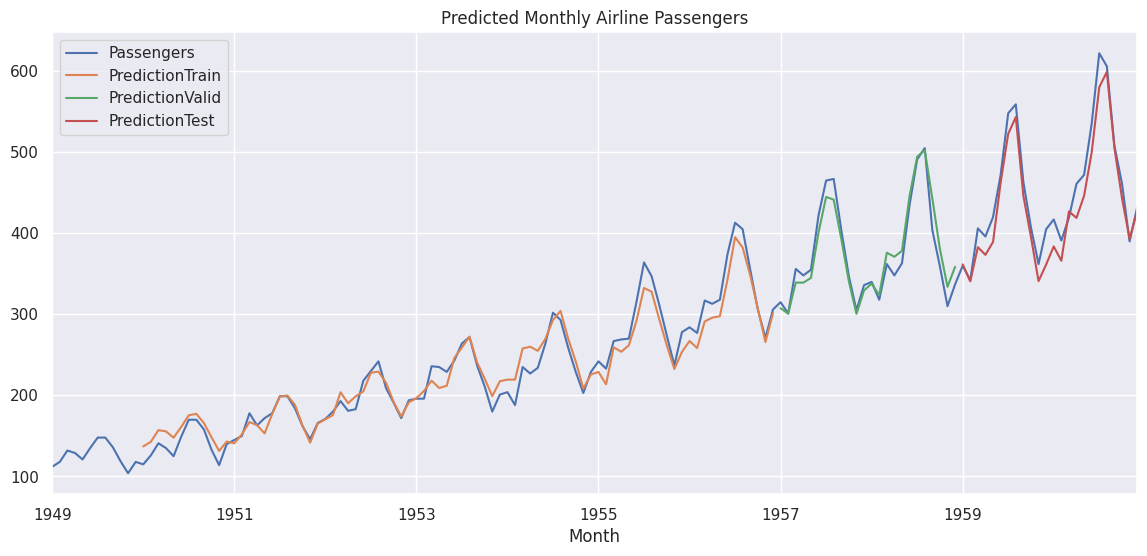

Train RMSE: 115.45, MAE: 95.28
Valid RMSE: 249.32, MAE: 242.86
Test RMSE: 327.04, MAE: 319.20


In [54]:
# Call the evaluation
evaluate_model(
    data, scaler,
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    y_date_train, y_date_valid, y_date_test,
    start_values,
    model
)